# Notebook para crear un fits RSS y un LOGCUBE a partir de un cubo de muse

In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np
from spectral_cube import SpectralCube

from scipy.interpolate import interp1d
from scipy.interpolate import splrep
from scipy.interpolate import splev

## Lectura de archivos fits
Para este ejemplo se utilizó el objeto 8083-12705 del catálogo de MaNGA (obtenido desde Marvin)

In [2]:
muse= fits.open('ADP.2016-08-01T16 14 36.611.fits')
rss= fits.open('cubes/manga-8083-12705-LOGRSS.fits.gz')

In [3]:
muse.info()

Filename: ADP.2016-08-01T16 14 36.611.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1326   ()      
  1  DATA          1 ImageHDU        43   (324, 322, 3681)   float32   
  2  STAT          1 ImageHDU        43   (324, 322, 3681)   float32   


In [4]:
rss.info()

Filename: cubes/manga-8083-12705-LOGRSS.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   ()      
  1  FLUX          1 ImageHDU        85   (4563, 1905)   float32   
  2  IVAR          1 ImageHDU        16   (4563, 1905)   float32   
  3  MASK          1 ImageHDU        16   (4563, 1905)   int32   
  4  LSFPOST       1 ImageHDU        10   (4563, 1905)   float32   
  5  LSFPRE        1 ImageHDU        10   (4563, 1905)   float32   
  6  WAVE          1 ImageHDU         9   (4563,)   float64   
  7  SPECRES       1 ImageHDU         9   (4563,)   float64   
  8  SPECRESD      1 ImageHDU         9   (4563,)   float64   
  9  PRESPECRES    1 ImageHDU         9   (4563,)   float64   
 10  PRESPECRESD    1 ImageHDU         9   (4563,)   float64   
 11  OBSINFO       1 BinTableHDU    148   15R x 65C   [25A, 17A, 5A, J, I, 8A, E, E, E, E, E, E, J, J, I, J, E, 12A, J, 8A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 13A,

## Obtención del Ivar y el flujo desde cubo de muse
-Se tomó un corte centrado en el objeto de 72x72 spaxels

-Centrado en (140,150)

In [6]:
x=slice(104,176)
y=slice(114,186)
xr=x.stop-x.start
yr=y.stop-y.start
xm=int(np.median(np.arange(0,xr)))
ym=int(np.median(np.arange(0,yr)))

In [7]:
data= muse[1].data

In [8]:
flujo= np.reshape(data[:,x,y],(3681,xr*yr))

## Definiendo los vectores de longitud de onda y resolusión espectral (paso a escala logarítmica)

In [15]:
wave= np.arange(4749.5576171875,9349.5576171875+1.25,1.25)
logwave= np.arange(np.log10(4749.5576171875),
                    (2942*10**(-4))+np.log10(4749.5576171875),1*10**(-4))
nwave=10**logwave
specres= nwave/0.026

In [16]:
#Interpolación del flujo para pasarlo a escala logaritmica 
flog=np.empty((2942,0))
for i in range (xr*yr):
    cu = interp1d(wave, flujo[:,i] ,kind='linear')
    flog= np.append(flog,np.transpose(np.array([cu(nwave)])),axis=1)
nans=np.where(np.isnan(flog))
flog[np.isnan(flog)]=0
nans

(array([   0,    1, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941,
        2941, 2941, 2941, 2941, 2941, 2941, 2941, 2941]),
 array([1748, 1748,   45,  105,  106,  107,  199,  202,  206,  207,  271,
         274,  276,  278,  279,  317,  323,  324,  327,  332,  333,  343,
         346,  348,  350,  351,  399,  404,  405,  407

## Generando el ivar para el nuevo cubo de MUSE 

In [25]:
stat= muse[2].data

In [26]:
theta2= stat[0:2942,x,y]

In [27]:
var= np.reshape(theta2,(2942,xr*yr))
var

array([[6086.188   , 5694.7236  , 8573.868   , ..., 7209.957   ,
        5361.8467  , 4981.3213  ],
       [3383.8972  , 3660.0908  , 2916.3982  , ..., 2691.139   ,
        1885.6787  , 2117.4958  ],
       [2953.463   , 3605.6094  , 2694.4219  , ..., 1669.3643  ,
        1788.7092  , 1530.0334  ],
       ...,
       [  76.51468 ,   61.12612 ,   59.314125, ...,   55.97684 ,
          57.35257 ,   49.695473],
       [  89.382515,   67.40379 ,   66.211784, ...,   52.821693,
          54.082813,   57.183086],
       [  81.18304 ,   65.315674,   67.98857 , ...,   52.2509  ,
          56.618805,   56.69233 ]], dtype=float32)

In [28]:
ivar= np.ma.power(var[:,], -1.0).filled(0.0)
ivar

array([[0.00016431, 0.0001756 , 0.00011663, ..., 0.0001387 , 0.0001865 ,
        0.00020075],
       [0.00029552, 0.00027322, 0.00034289, ..., 0.00037159, 0.00053031,
        0.00047226],
       [0.00033859, 0.00027735, 0.00037114, ..., 0.00059903, 0.00055906,
        0.00065358],
       ...,
       [0.01306939, 0.01635962, 0.01685939, ..., 0.01786453, 0.01743601,
        0.02012256],
       [0.01118787, 0.01483596, 0.01510305, ..., 0.01893162, 0.01849016,
        0.01748769],
       [0.01231784, 0.01531026, 0.01470835, ..., 0.01913843, 0.01766198,
        0.01763907]], dtype=float32)

## Obtención de xpos e ypos desde el cubo de muse

In [30]:
cube = SpectralCube.read('ADP.2016-08-01T16 14 36.611.fits', hdu=1)

In [31]:
m=cube.world[:,y,x]
#[DATO:0=long,1=dec,2=ra][Longitud][ejex][ejey]

In [32]:
centros=np.empty((0,2))
for i in range(2942):
    c=np.array([[m[2][i][xm][ym].value*3600,m[1][i][xm][ym].value*3600]])
    centros= np.append(centros,c,axis=0)
#centros=[ra,dec] en arcsec

In [33]:
centros

array([[180646.7005248,  -3987.0715485],
       [180646.7005248,  -3987.0715485],
       [180646.7005248,  -3987.0715485],
       ...,
       [180646.7005248,  -3987.0715485],
       [180646.7005248,  -3987.0715485],
       [180646.7005248,  -3987.0715485]])

In [34]:
pos=np.empty((0,2,xr,yr))
for i in range(2942):
    p= np.array([[m[2][i][:][:].value*3600-centros[i][0], m[1][i][:][:].value*3600-centros[i][1]]])
    pos= np.append(p,pos,axis=0)
#pos[Longitud][1=ra,2=dec][ejex][ejey]

In [35]:
pos[2941][1][xm][ym]

0.0

In [36]:
xpos=np.reshape(pos[:,0,:,:],(2942,xr*yr))
ypos=np.reshape(pos[:,1,:,:],(2942,xr*yr))

## Construcción del RSS

In [38]:
header= rss[0].header

In [39]:
#Máscaras, se usa 0 para spaxels sin máscaras, 1027 para spaxels enmascarados
mask= np.zeros((2942,xr,yr),dtype=int)
maskrss= np.reshape(mask,(2942,xr*yr))

In [40]:
h= fits.PrimaryHDU(header=header)
f= fits.ImageHDU(np.swapaxes(flog,0,1), name='FLUX')
v= fits.ImageHDU(np.swapaxes(ivar,0,1), name='IVAR')
xp= fits.ImageHDU(np.swapaxes(xpos,0,1), name='XPOS')
yp= fits.ImageHDU(np.swapaxes(ypos,0,1), name='YPOS')
s= fits.ImageHDU(specres, name='SPECRES')
w= fits.ImageHDU(nwave, name='WAVE')
mar= fits.ImageHDU(np.swapaxes(maskrss,0,1),name='MASK')

In [41]:
h.header['VERSDRP3']= 'v3_1_1  '
h.header['NEXP']= 1
f.header['DRP3QUAL']= 0
h.header['DRP3QUAL']= 0
h.header['OBJRA']= 50.1784165840687
h.header['OBJDEC']= -1.10690876373023

In [42]:
hdul= fits.HDUList([h,f,v,mar,w,s,xp,yp])

In [43]:
hdul.writeto('manga-8083-12705-LOGRSS.fits.gz')

In [20]:
testRSS= fits.open('manga-8083-12705-LOGRSS.fits.gz')

In [21]:
testRSS.info()

Filename: manga-8083-12705-LOGRSS.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      69   ()      
  1  FLUX          1 ImageHDU         9   (2942, 5184)   float64   
  2  IVAR          1 ImageHDU         8   (2942, 5184)   float32   
  3  MASK          1 ImageHDU         8   (2942, 5184)   int64   
  4  WAVE          1 ImageHDU         7   (2942,)   float64   
  5  SPECRES       1 ImageHDU         7   (2942,)   float64   
  6  XPOS          1 ImageHDU         8   (2942, 5184)   float64   
  7  YPOS          1 ImageHDU         8   (2942, 5184)   float64   


## Creación del logcube

In [47]:
museh= muse[0].header
museh.set('EBVGAL', 0.0721933)

In [48]:
flujo2= np.reshape(flog,(2942,xr,yr))
ivar2= np.ma.power(theta2[0:2942,], -1.0).filled(0.0)

In [49]:
h2= fits.PrimaryHDU(header=museh)
f2= fits.ImageHDU(flujo2,name='FLUX')
i= fits.ImageHDU(ivar2,name='IVAR')
ma= fits.ImageHDU(mask,name='MASK')

In [50]:
f2.header['CTYPE3']= 'WAVE-LOG'
f2.header['CUNIT3']= 'Angstrom'
f2.header['DATE-OBS']= '2016-01-27T03:14:27.320'
f2.header['MJD-OBS']= 57414.13503843
f2.header['CRPIX3']= 1
f2.header['CRVAL3']= 4749.5576171875
f2.header['CD3_3']= 1.25
f2.header['DRP3QUAL']= 0
h2.header['VERSDRP3']= 'v3_1_1  '
h2.header['DRP3QUAL']= 0
h2.header['OBJRA']= 50.1784165840687
h2.header['OBJDEC']= -1.10690876373023

In [51]:
hdul2= fits.HDUList([h2,f2,i,ma,w,s])

In [52]:
hdul2.writeto('manga-8083-12705-LOGCUBE.fits.gz')

In [18]:
testLOG= fits.open('manga-8083-12705-LOGCUBE.fits.gz')

In [19]:
testLOG.info()

Filename: manga-8083-12705-LOGCUBE.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1331   ()      
  1  FLUX          1 ImageHDU        17   (72, 72, 2942)   float64   
  2  IVAR          1 ImageHDU         9   (72, 72, 2942)   float32   
  3  MASK          1 ImageHDU         9   (72, 72, 2942)   int64   
  4  WAVE          1 ImageHDU         7   (2942,)   float64   
  5  SPECRES       1 ImageHDU         7   (2942,)   float64   


## Plots

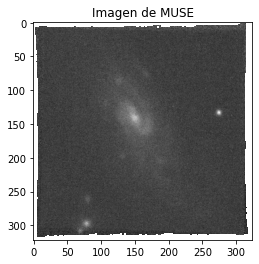

In [30]:
plt.imshow(data[2000],cmap='gray')
plt.title('Imagen de MUSE')
plt.savefig('muse.png')
plt.show()

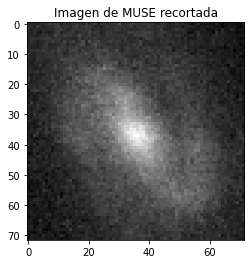

In [31]:
plt.imshow(testLOG[1].data[2000],cmap='gray')
plt.title('Imagen de MUSE recortada')
plt.savefig('musemini.png')
plt.show()

## Notas y otros

In [ ]:
#WAVELMIN=      474.95576171875 / [nm] Minimum wavelength  (muse[0]header)                      
#WAVELMAX=      934.95576171875 / [nm] Maximum wavelength  (muse[0]header)
#CD3_3   =      1.25 / saltos longitud de onda  (muse[1]header)
#CRDER3  =      0.026 / [Angstrom] Random error in spectral coordinate (muse[1]header)
#specres=       wave/0.026
#EBVGAL ? =            0.0721933 / Galactic reddening E(B-V)  (rss[0].header)
#Redshift (z) 	0.02091116

In [46]:
#Función interp1d
li = interp1d(wave, flujo[:,5],kind='linear')
nt = interp1d(wave, flujo[:,5],kind='nearest')
nu = interp1d(wave, flujo[:,5],kind='nearest-up')
ze = interp1d(wave, flujo[:,5],kind='zero')
sl = interp1d(wave, flujo[:,5],kind='slinear')
qu = interp1d(wave, flujo[:,5],kind='quadratic')
cu = interp1d(wave, flujo[:,5],kind='cubic')
pr = interp1d(wave, flujo[:,5],kind='previous')
ne = interp1d(wave, flujo[:,5],kind='next')

#Spline interpolation
spl= splrep(wave, flujo[:,5])
yn = splev(nwave,spl)

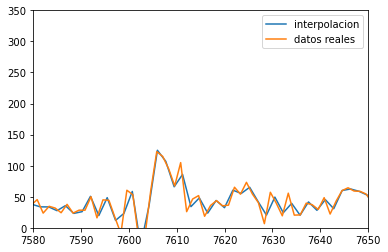

In [47]:
plt.plot(nwave,cu(nwave),label="interpolacion")
plt.plot(wave,flujo[:,5], label= "datos reales")
plt.xlim(7580,7650)
plt.ylim(0,350)
plt.legend()

In [48]:
#aplicar a todos los spaxels
cu = interp1d(wave, flujo[:,5] ,kind='cubic')